In [1]:
# Hello

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.imports import *

In [3]:
#!pip install "torch==1.4" "torchvision==0.5.0"

In [4]:
import fastai
import torch
print(torch.__version__)
print(fastai.__version__)

1.7.0
1.0.61


In [5]:
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

### Data

In [6]:
path = Path('path')

In [7]:
np.random.seed(41)

In [8]:
#np.random.seed(41)
#data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
#data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4, ).normalize()
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",ds_tfms=get_transforms(), size=(256,256), bs=150, num_workers=4, ).normalize()

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [10]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 500
Number of examples in validation: 125


In [11]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([150, 3, 256, 256]), torch.Size([150]))

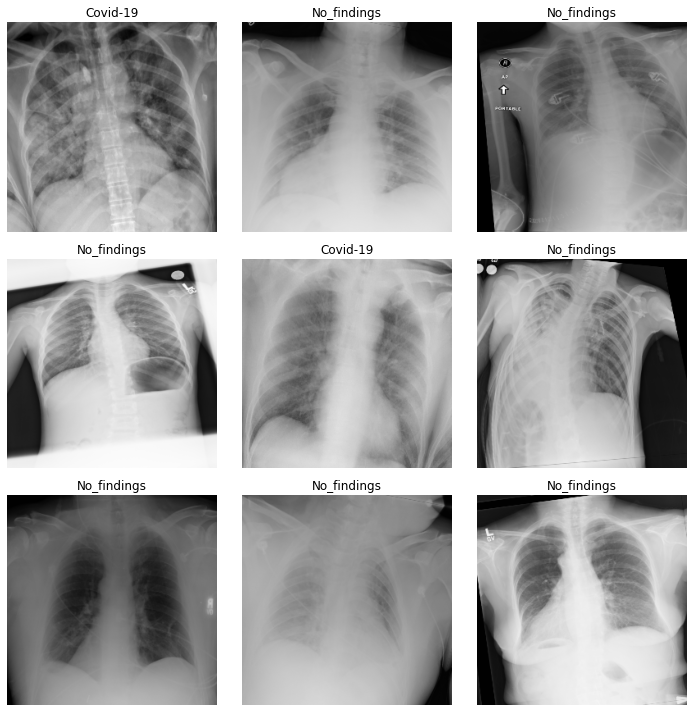

In [12]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## covid-aid (modified Darknet model)

In [13]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [14]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [15]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [16]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    maxpooling(),
    conv_block(256, 512, size = 1),
    conv_block(512, 256, size = 1),
    conv_block(256, 128, size = 1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(242, 2)
)
# model = nn.Sequential(
#     conv_block(3, 8),
#     maxpooling(),
#     conv_block(8, 16),
#     maxpooling(),
#     triple_conv(16, 64),
#     maxpooling(),
#     triple_conv(64, 128),
#     maxpooling(),
#     triple_conv(128, 256),
#     conv_block(256, 128, size=1),
#     conv_block(128, 256),
#     conv_layer(256, 2),
#     Flatten(),
#     nn.Linear(338, 2)
# )

In [17]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [18]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [19]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 

In [20]:
learn.fit_one_cycle(30, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.605204,0.729084,0.200000,01:21
1,0.492062,0.741625,0.200000,01:24
2,0.435750,0.739887,0.200000,00:34
3,0.380356,0.742086,0.200000,00:29
4,0.332417,0.736943,0.200000,00:27
5,0.301264,0.748200,0.200000,00:36
6,0.292403,0.666707,0.704000,00:28
7,0.273267,0.502118,0.784000,00:28
8,0.250969,0.388375,0.888000,00:28
9,0.235285,0.235595,0.912000,00:28


In [21]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 125


In [22]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [23]:
accuracy(probs,targets)

tensor(0.9680)

In [24]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [25]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 121 0.968
[[22  3]
 [ 1 99]]
              precision    recall  f1-score   support

    Covid-19       0.96      0.88      0.92        25
 No_findings       0.97      0.99      0.98       100

    accuracy                           0.97       125
   macro avg       0.96      0.94      0.95       125
weighted avg       0.97      0.97      0.97       125



In [26]:
interp = ClassificationInterpretation.from_learner(learn)

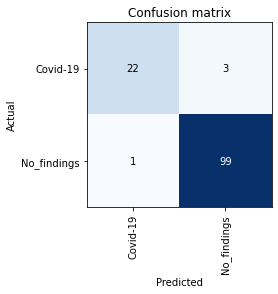

In [27]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);